# LVC GW Targets

Generate a target list of host galaxies given the 50% and 90% credible localization regions of a GW alert.

In [10]:
from astropy.io import fits

import healpy as hp

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from gw_skymap import compute_quantiles, compute_contours, plot_gwmap

from desitarget.io import read_targets_in_hp, read_targets_in_box, read_targets_in_cap, check_hp_target_dir
from desitarget.targetmask import desi_mask, bgs_mask

## Read GW LALInference Map

Extract localization PDF for a GW event and plot it using the DESI footprint.

Data can be downloaded from the [LVC GraceDB public alert page](https://gracedb.ligo.org/).

In [11]:
fits_file = 'S200224ca_LALInference.fits.gz'

# Read metadata.
hdus = fits.open(fits_file)
header = hdus[1].header

# instruments = header['INSTRUME']
distmean = header['DISTMEAN']
diststd = header['DISTSTD']
origin = header['ORIGIN']
date = header['DATE']

gwmap = hp.read_map(fits_file)
nside = hp.npix2nside(len(gwmap))

NSIDE = 1024
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING


In [12]:
# Compute GW quantiles.
levels = [0.50, 0.90]
lev_vals = compute_quantiles(levels, gwmap)
print(levels, lev_vals)

# # Compute GW contours.
# prob64 = hp.pixelfunc.ud_grade(gwmap, 64) #reduce nside to make it faster
# prob64 = prob64/np.sum(prob64)
# pixels = np.arange(prob64.size)
# #sample_points = np.array(hp.pix2ang(nside,pixels)).T
# theta_contour, phi_contour = compute_contours(levels, prob64)

[0.5, 0.9] [5.739633330429371e-05, 5.236019043722391e-06]


NSIDE = 1024
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
NSIDE = 1024
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 45 deg 0.00'.


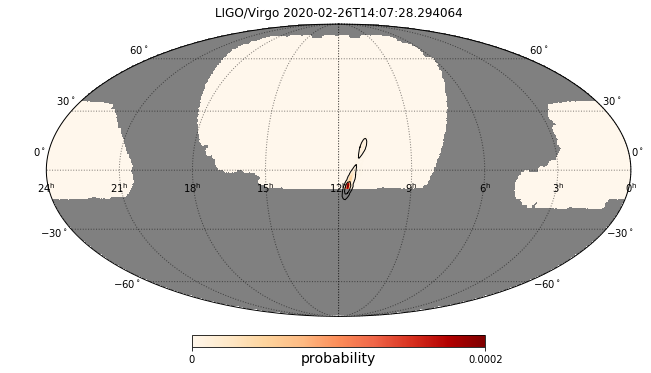

In [13]:
fig = plot_gwmap('S200224ca_LALInference.fits.gz', levels=[0.5, 0.9])
fig.savefig('gw_skymap.png', dpi=100)

In [14]:
maxpix = np.argmax(gwmap)
ra, dec = hp.pix2ang(nside, maxpix, lonlat=True)
print(ra, dec)
# print(ramin, ramax, decmin, decmax)

173.8916015625 -8.084013907099305


## Load DR8 Targets

Using the code from the [DESI target example notebook](https://github.com/qmxp55/desi_uk_meeting_2019/blob/master/desitarget_local_example.ipynb) created by Omar Macias, extract the targets within a box surrounding the 90% C.I.

In [ ]:
# Load sample of resolve DR8 target catalogue
hpdirname = '/global/projecta/projectdirs/desi/target/catalogs/dr8/0.32.0/targets/main/resolve/bright'

# Read targets in an RA, Dec, radius (degrees) "circle".
# radecrad = [ra ,dec,15]
# captargs = read_targets_in_cap(hpdirname, radecrad)
radecbox = [ramin, ramax, decmin, decmax]
captargs = read_targets_in_box(hpdirname, radecbox)

print('# rows = %i' %(len(captargs)))
print('# cols = %i' %(len(captargs.dtype.names)))

### Select Targets

Identify targets within the 50% and 90% contours, and apply a basic cut on bright BGS objects.

In [ ]:
cappix = hp.ang2pix(nside, captargs['RA'], captargs['DEC'], lonlat=True)
is50 = gwmap[cappix] > lev_vals[0]
is90 = gwmap[cappix] > lev_vals[1]

bgs_bright = (captargs['BGS_TARGET'] & bgs_mask['BGS_BRIGHT']) != 0

In [ ]:
select50 = np.logical_and(is50, bgs_bright)
ra50, dec50 = [captargs[_][select50] for _ in ['RA', 'DEC']]

select90 = np.logical_and(is90, bgs_bright)
ra90, dec90 = [captargs[_][select90] for _ in ['RA', 'DEC']]

rmag = 22.5 - 2.5*np.log10(captargs['FLUX_R'][select90])
rthr = np.max(rmag)

print('{:8d} targets in 50% C.I. with rmag > {:g}'.format(len(ra50), rthr))
print('{:8d} targets in 90% C.I. with rmag > {:g}'.format(len(ra90), rthr))

In [ ]:
captargs.dtype.names

In [ ]:
captargs[select50]['BRICKID']

In [ ]:
captargs[select50]['BRICKNAME']

In [ ]:
np.unique(captargs[select50]['BRICKID'])

### Plot the Targets

In [ ]:
fig = plt.figure(1, figsize=(4,6))

hp.cartview(probs, fig=1, cmap=cmap, lonra=[ramin, 180], latra=[decmin, decmax], min=0, max=2e-4,
            title='Targets: S200224ca', unit=r'Pr$(\alpha,\delta)$', flip='astro')
hp.projplot(ra50, dec50, 'k,', alpha=0.1, lonlat=True);
hp.projplot(ra90, dec90, 'k,', alpha=0.1, lonlat=True);

# Add tile 70502
ra_c, dec_c = 180., -0.5
ra70502 = [ra_c + 1.6*np.cos(th) for th in np.linspace(0, 2*np.pi, 201)]
dec70502 = [dec_c + 1.6*np.sin(th) for th in np.linspace(0, 2*np.pi, 201)]
hp.projplot(ra70502, dec70502, 'k-', lw=1, lonlat=True)
hp.projtext(ra_c-1, dec_c+2, 'Tile 70502', lonlat=True, fontsize=8)

fig = plt.gcf()
fig.savefig('targlist.png', dpi=150)